In [2]:
# ONLY RUN THIS CELL ONCE
import os
os.chdir("..")

In [3]:
import torch
from torch.utils.data import Dataset
import pandas as pd
class CoordDataset(Dataset):
    def __init__(self):
        df = pd.read_csv("datasets/coord_dataset.csv")
        self.X = torch.tensor(df.to_numpy()[:, 1:-1], dtype=torch.float32)
        self.y = torch.tensor(df.to_numpy()[:, -1], dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
dataset = CoordDataset()
dataset.X.shape, dataset.y.shape

(torch.Size([3544, 36]), torch.Size([3544]))

In [4]:
torch.manual_seed(42)
train, val, test = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])

In [5]:
len(train), len(val), len(test)

(2127, 709, 708)

In [6]:
import torch.nn as nn
import torch
from models.models import CN_S50_4_D0

model = CN_S50_4_D0()
model

CN_S50_4_D0(
  (net): Sequential(
    (0): Linear(in_features=36, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=8, bias=True)
  )
)

In [6]:
EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [8]:
from torch.utils.data import DataLoader
from tqdm import tqdm

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
for epoch in (pbar := tqdm(range(EPOCHS))):
    for X, y in train_loader:
        model.zero_grad()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
    pbar.set_description(f"Epoch {epoch} -> Loss: {loss.item():.4f}")


Epoch 999 -> Loss: 0.1950: 100%|██████████| 1000/1000 [00:17<00:00, 56.53it/s]


In [12]:
torch.save(model.state_dict(), "models/model_state_dict_CN_S50_4_D0.pt")

In [9]:
model = CN_S50_4_D0()
model.load_state_dict(torch.load("../models/model_state_dict_CN_S50_4_D0.pt"))
model.eval()
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for X, y in train_loader:
        y_hat = model(X)
        _, predicted = torch.max(y_hat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
accuracy = correct / total
print(f"Accuracy on train dataset: {accuracy:.2f}")


Accuracy on train dataset: 0.94


In [10]:
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for X, y in val_loader:
        y_hat = model(X)
        _, predicted = torch.max(y_hat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
accuracy = correct / total
print(f"Accuracy on val dataset: {accuracy:.2f}")


Accuracy on val dataset: 0.88


In [11]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        _, predicted = torch.max(y_hat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
accuracy = correct / total
print(f"Accuracy on test dataset: {accuracy:.2f}")


Accuracy on test dataset: 0.89


In [15]:
import numpy as np
np.unique(dataset.y[val.indices], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 76, 226, 132,  73,  16,  14,  82,  90]))

In [16]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([1, 2])
a / b[:, None]

array([[1. , 2. , 3. ],
       [2. , 2.5, 3. ]])

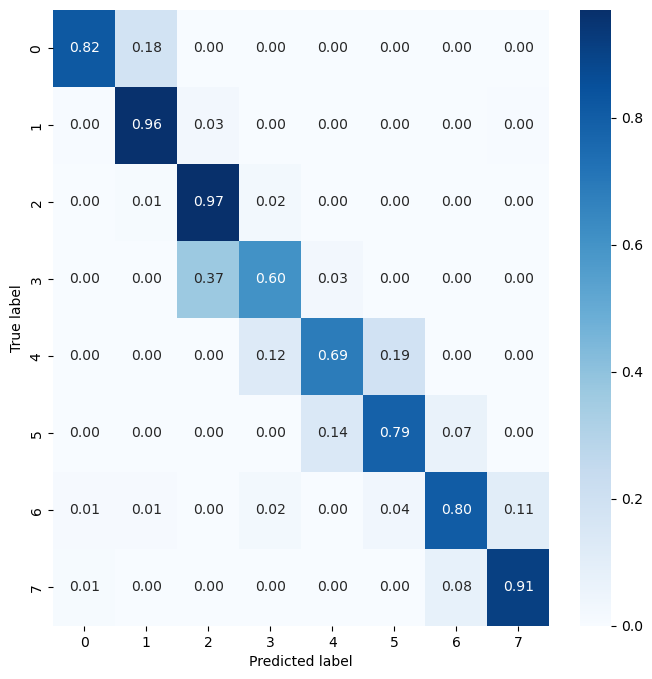

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models.models import CN_S50_4_D0
import numpy as np

# get predicted labels for val dataset
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
y_true = []
y_pred = []
model = CN_S50_4_D0()
model.load_state_dict(torch.load("models/model_state_dict_CN_S50_4_D0.pt"))
model.eval()
for X, y in val_loader:
    y_hat = model(X)
    _, predicted = torch.max(y_hat.data, 1)
    y_true.extend(y.numpy())
    y_pred.extend(predicted.numpy())

# get confusion matrix
cm = confusion_matrix(y_true, y_pred)
value_counts = np.unique(dataset.y[val.indices], return_counts=True)[1]
cm = cm / value_counts[:, None]
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=range(8), yticklabels=range(8))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [18]:
model = CN_S50_4_D0()
model.load_state_dict(torch.load("../models/model_state_dict_CN_S50_4_D0.pt"))
model.eval()

CN_S50_4_D0(
  (net): Sequential(
    (0): Linear(in_features=36, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=8, bias=True)
  )
)

In [20]:
import torch
import os
import cv2
import mediapipe as mp
import sys
sys.path.insert(0, '../pose/')
from pose import *
from matplotlib import pyplot as plt
import pandas as pd

detector = create_detector('pose_landmarker_lite.task')
video_tag = 'Stage8/Stage8_R1hb1.mp4'
video_path = f'/Users/tanayagrawal/PycharmProjects/sportsai/Tennis/RData/{video_tag}'
cap = cv2.VideoCapture(video_path)

columns = []
for i in BOTH_ARM_MARKERS:
    columns.extend([f"x{i}", f"y{i}", f"z{i}"])
pose_data = pd.DataFrame(columns=columns)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
rows = (total_frames + 4) // 5
frames = 0
fig = plt.figure(figsize=(9,16))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    detection_result = detector.detect(mp_image)
    if len(detection_result.pose_landmarks) < 1:
        continue
    pose_landmarks = detection_result.pose_landmarks[0]
    left_hip = pose_landmarks[LEFT_HIP]
    right_hip = pose_landmarks[RIGHT_HIP]
    center = (left_hip.x + right_hip.x) / 2, (left_hip.y + right_hip.y) / 2, (left_hip.z + right_hip.z) / 2
    translated_landmarks = []
    for j in BOTH_ARM_MARKERS:
        translated_landmarks.extend([
            pose_landmarks[j].x - center[0], 
            pose_landmarks[j].y - center[1], 
            pose_landmarks[j].z - center[2], 
        ])
    pose_data.loc[len(pose_data)] = translated_landmarks

    pose_data_tensor = torch.tensor(pose_data.values.astype(np.float32))
    output = model(pose_data_tensor)
    x = torch.max(output, dim=1).indices
    pred_stage = torch.mode(x).values.item() +1
    
    ax = fig.add_subplot(rows, 5, frames+1)
    ax.set_title('Stage '+ str(pred_stage))
    ax.imshow(frame)
    ax.axis('off')
    frames+=1
 
plt.tight_layout()
plt.show()
cap.release()

pose_data_tensor = torch.tensor(pose_data.values.astype(np.float32))
output = model(pose_data_tensor)
x = torch.max(output, dim=1).indices
pred_stage = torch.mode(x).values.item() +1
print(video_tag + " - Final Predicted Stage: " + str(pred_stage))

if "Stage"+str(pred_stage) == video_tag[:6]:
    print("Prediction was correct!")
else:
    print("Incorrect.")

ModuleNotFoundError: No module named 'pose'